In [64]:
!pip install imblearn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from outlier import outlier_detection,multi_outlier
from missing_value import missingValue_Treat
from scipy.stats import norm,boxcox
from Features import features
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import Normalizer,StandardScaler

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import classification_report,roc_auc_score
#from run_gbm import run_gbm
from xgboost import XGBClassifier as xgbc
from lightgbm import LGBMClassifier
import lightgbm as lgb
import h5py
import time

In [2]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',500)

## Read Data

In [3]:
train = pd.read_csv('train.csv')


In [4]:
test = pd.read_csv('test.csv')

In [5]:
train.shape,test.shape

((245725, 11), (105312, 10))

In [6]:
dummy = pd.read_csv('test.csv')

In [7]:
ID=dummy['ID']

In [8]:
train.head()

ID  Gender  Age Region_Code     Occupation Channel_Code  Vintage  \
0  NNVBBKZB  Female   73       RG268          Other           X3       43   
1  IDD62UNG  Female   30       RG277       Salaried           X1       32   
2  HD3DSEMC  Female   56       RG268  Self_Employed           X3       26   
3  BF3NC7KV    Male   34       RG270       Salaried           X1       19   
4  TEASRWXV  Female   30       RG282       Salaried           X1       33   

  Credit_Product  Avg_Account_Balance Is_Active  Is_Lead  
0             No              1045696        No        0  
1             No               581988        No        0  
2             No              1484315       Yes        0  
3             No               470454        No        0  
4             No               886787        No        0

In [9]:
x=train[~train.iloc[:,1:].duplicated(keep='first')]
train=train[~train.ID.isin(x[x.iloc[:,1:-1].duplicated(keep=False)].ID)]


In [10]:
x.shape

(245704, 11)

In [11]:
train.shape

(245721, 11)

## Data Discrepancy

In [11]:
train.dtypes

ID                     object
Gender                 object
Age                     int64
Region_Code            object
Occupation             object
Channel_Code           object
Vintage                 int64
Credit_Product         object
Avg_Account_Balance     int64
Is_Active              object
Is_Lead                 int64
dtype: object

In [12]:
test.dtypes

ID                     object
Gender                 object
Age                     int64
Region_Code            object
Occupation             object
Channel_Code           object
Vintage                 int64
Credit_Product         object
Avg_Account_Balance     int64
Is_Active              object
dtype: object

#### Missing Values

In [13]:
train.isna().sum()/train.shape[0]

ID                     0.000000
Gender                 0.000000
Age                    0.000000
Region_Code            0.000000
Occupation             0.000000
Channel_Code           0.000000
Vintage                0.000000
Credit_Product         0.119343
Avg_Account_Balance    0.000000
Is_Active              0.000000
Is_Lead                0.000000
dtype: float64

In [14]:
test.isna().sum()/test.shape[0]

ID                     0.000000
Gender                 0.000000
Age                    0.000000
Region_Code            0.000000
Occupation             0.000000
Channel_Code           0.000000
Vintage                0.000000
Credit_Product         0.118904
Avg_Account_Balance    0.000000
Is_Active              0.000000
dtype: float64

### Data Quality Check

In [15]:
train['Gender'].value_counts()/train.shape[0]

Male      0.546119
Female    0.453881
Name: Gender, dtype: float64

In [16]:
test['Gender'].value_counts()/test.shape[0]

Male      0.547943
Female    0.452057
Name: Gender, dtype: float64

In [17]:
train['Occupation'].value_counts()/train.shape[0]

Self_Employed    0.410563
Salaried         0.293003
Other            0.285580
Entrepreneur     0.010854
Name: Occupation, dtype: float64

In [18]:
test['Occupation'].value_counts()/test.shape[0]

Self_Employed    0.410134
Salaried         0.293537
Other            0.286112
Entrepreneur     0.010217
Name: Occupation, dtype: float64

In [19]:
train['Channel_Code'].value_counts()/train.shape[0]

X1    0.422088
X3    0.279634
X2    0.275613
X4    0.022664
Name: Channel_Code, dtype: float64

In [20]:
test['Channel_Code'].value_counts()/test.shape[0]

X1    0.422402
X3    0.277927
X2    0.277043
X4    0.022628
Name: Channel_Code, dtype: float64

In [21]:
train['Credit_Product'].value_counts()/train.shape[0]

No     0.587475
Yes    0.293182
Name: Credit_Product, dtype: float64

In [22]:
test['Credit_Product'].value_counts()/test.shape[0]

No     0.585005
Yes    0.296092
Name: Credit_Product, dtype: float64

In [23]:
train['Is_Active'].value_counts()/train.shape[0]

No     0.61162
Yes    0.38838
Name: Is_Active, dtype: float64

In [24]:
test['Is_Active'].value_counts()/test.shape[0]

No     0.60579
Yes    0.39421
Name: Is_Active, dtype: float64

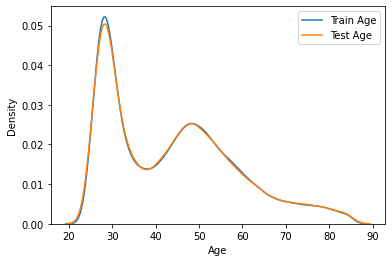

In [25]:
sns.distplot(train['Age'],hist=False,label='Train Age')
sns.distplot(test['Age'],hist=False,label='Test Age')
plt.legend()

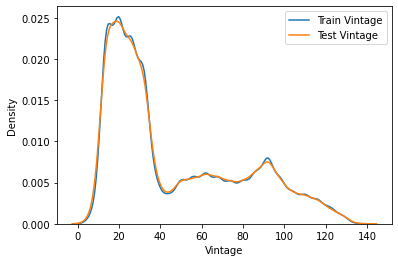

In [26]:
sns.distplot(train['Vintage'],hist=False,label='Train Vintage')
sns.distplot(test['Vintage'],hist=False,label='Test Vintage')
plt.legend()

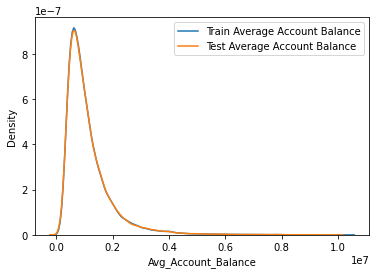

In [27]:
sns.distplot(train['Avg_Account_Balance'],hist=False,label='Train Average Account Balance')
sns.distplot(test['Avg_Account_Balance'],hist=False,label='Test Average Account Balance')
plt.legend()

#### Skewness

In [28]:
train['Avg_Account_Balance'].skew()

2.9687606966438422

In [29]:
train['Vintage'].skew()

0.7901669952800069

In [30]:
train['Age'].skew()

0.6189787335860392

#### Outliers

<AxesSubplot:xlabel='Age'>

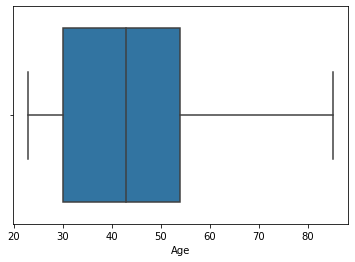

In [31]:
sns.boxplot(train['Age'])

<AxesSubplot:xlabel='Vintage'>

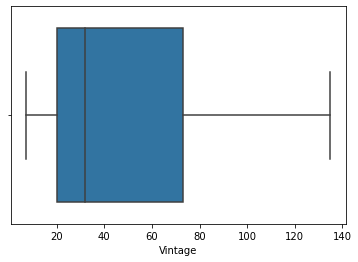

In [32]:
sns.boxplot(train['Vintage'])

<AxesSubplot:xlabel='Avg_Account_Balance'>

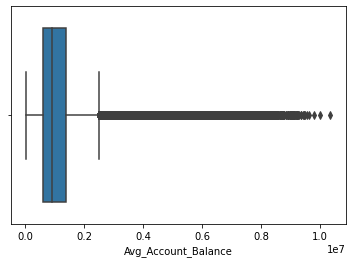

In [33]:
sns.boxplot(train['Avg_Account_Balance'])

<AxesSubplot:xlabel='Is_Lead', ylabel='Avg_Account_Balance'>

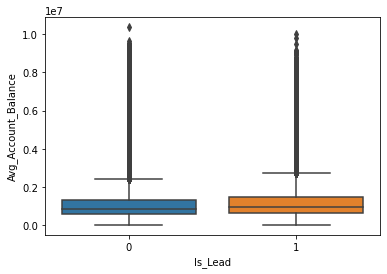

In [34]:
sns.boxplot(train['Is_Lead'],train['Avg_Account_Balance'])

<AxesSubplot:xlabel='Is_Lead', ylabel='Vintage'>

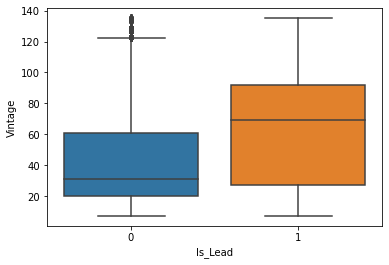

In [35]:
sns.boxplot(train['Is_Lead'],train['Vintage'])

<AxesSubplot:xlabel='Is_Lead', ylabel='Age'>

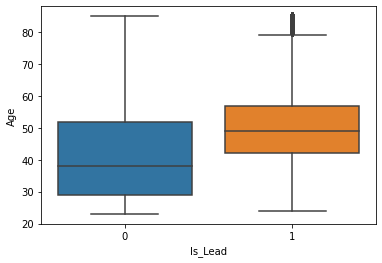

In [36]:
sns.boxplot(train['Is_Lead'],train['Age'])

### Anomaly Treatment

In [12]:
train=multi_outlier(condition=1,df=train,on_Col='Is_Lead',out_Col='Age')


<AxesSubplot:xlabel='Is_Lead', ylabel='Age'>

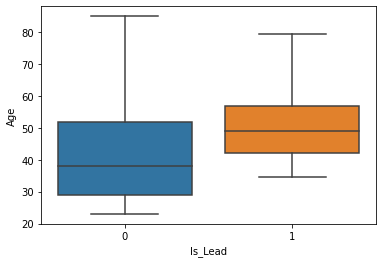

In [12]:
sns.boxplot(train['Is_Lead'],train['Age'])

In [13]:
train=multi_outlier(condition=0,df=train,on_Col='Is_Lead',out_Col='Vintage')


<AxesSubplot:xlabel='Is_Lead', ylabel='Vintage'>

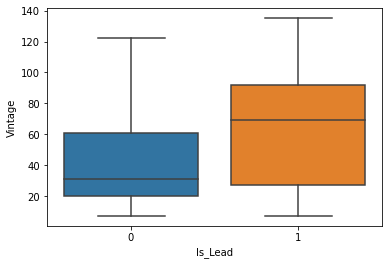

In [40]:
sns.boxplot(train['Is_Lead'],train['Vintage'])

In [14]:
outlier_detection(df=train,col='Avg_Account_Balance')
outlier_detection(df=test,col='Avg_Account_Balance')

<AxesSubplot:xlabel='Avg_Account_Balance'>

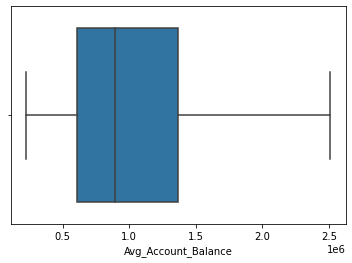

In [42]:
sns.boxplot(train['Avg_Account_Balance'])

<AxesSubplot:xlabel='Is_Lead', ylabel='Avg_Account_Balance'>

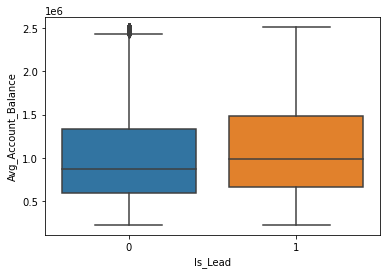

In [14]:
sns.boxplot(train['Is_Lead'],train['Avg_Account_Balance'])

In [15]:
train=multi_outlier(condition=0,df=train,on_Col='Is_Lead',out_Col='Avg_Account_Balance')


<AxesSubplot:xlabel='Is_Lead', ylabel='Avg_Account_Balance'>

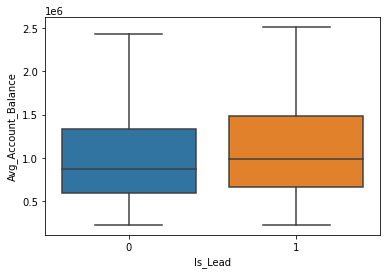

In [45]:
sns.boxplot(train['Is_Lead'],train['Avg_Account_Balance'])

In [16]:
missingValue_Treat(df=train,col='Credit_Product')
missingValue_Treat(df=test,col='Credit_Product')

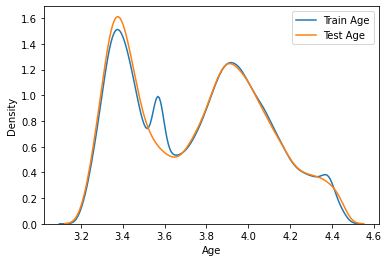

In [48]:
sns.distplot(np.log1p(train['Age']),hist=False,label='Train Age')
sns.distplot(np.log1p(test['Age']),hist=False,label='Test Age')
plt.legend()

In [17]:
train['Age_Bracket']=pd.qcut(train['Age'],3).astype('object').astype(str)
test['Age_Bracket']=pd.qcut(test['Age'],3).astype('object').astype(str)

In [18]:
train['Age_Bracket'].value_counts()

(22.999, 34.0]    84665
(34.0, 50.0]      82027
(50.0, 85.0]      79029
Name: Age_Bracket, dtype: int64

In [18]:
train['Age_Bracket'].replace({'(22.999, 34.0]':'Young','(34.0, 50.0]':'Mid-Age','(50.0, 85.0]':'Old'},inplace=True)

In [145]:
test['Age_Bracket'].value_counts()

(32.0, 50.0]      36215
(23.999, 32.0]    35401
(50.0, 85.0]      33696
Name: Age_Bracket, dtype: int64

In [19]:
test['Age_Bracket'].replace({'(23.999, 32.0]':'Young','(32.0, 50.0]':'Mid-Age','(50.0, 85.0]':'Old'},inplace=True)

In [20]:
fitted_data,_=boxcox(train['Age'])
test_fitted_data,_=boxcox(test['Age'])


<AxesSubplot:ylabel='Density'>

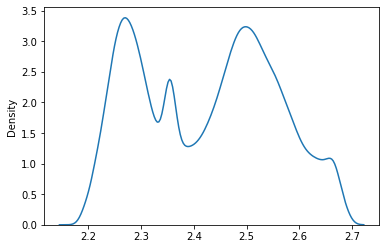

In [19]:
sns.distplot(fitted_data,hist=False)

In [21]:
train.loc[:,'Age']=fitted_data
test.loc[:,'Age']=test_fitted_data

In [19]:
train['Age'].skew()

0.031801970350311605

<AxesSubplot:xlabel='Vintage', ylabel='Density'>

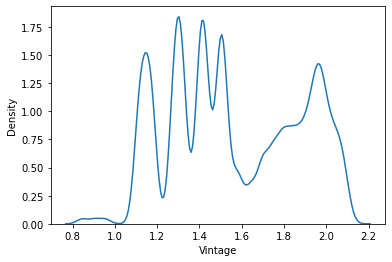

In [54]:
sns.distplot(np.log10(train['Vintage']),hist=False)

In [22]:
train.loc[:,'Vintage']=np.log(train['Vintage'])
test.loc[:,'Vintage']=np.log(test['Vintage'])

In [23]:
train['Vintage'].skew()

0.10810037884503777

<AxesSubplot:xlabel='Avg_Account_Balance', ylabel='Density'>

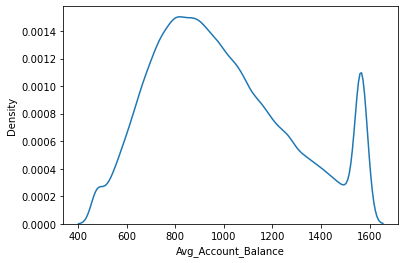

In [24]:
sns.distplot(np.sqrt(train['Avg_Account_Balance']),hist=False)

In [23]:
train.loc[:,'Avg_Account_Balance']=np.sqrt(train['Avg_Account_Balance'])
test.loc[:,'Avg_Account_Balance']=np.sqrt(test['Avg_Account_Balance'])

In [22]:
train.loc[:,'Avg_Account_Balance'].skew()

0.4833252794821886

In [61]:
train['Is_Lead'].value_counts()/train.shape[0]

0    0.762796
1    0.237204
Name: Is_Lead, dtype: float64

## Data Insights

In [15]:
train.head()

ID  Gender   Age Region_Code     Occupation Channel_Code  Vintage  \
6   ETQCZFEJ    Male  62.0       RG282          Other           X3     20.0   
15  UJ2NJKKL    Male  34.5       RG268  Self_Employed           X2     69.0   
16  CNGSPYWS  Female  46.0       RG268          Other           X3     97.0   
17  VH7NBNNQ  Female  59.0       RG283          Other           X3     15.0   
20  7PMYNWB3    Male  44.0       RG269  Self_Employed           X2     19.0   

   Credit_Product  Avg_Account_Balance Is_Active  Is_Lead  
6              No            1056750.0       Yes        1  
15             No             517063.0       Yes        1  
16            Yes            2282502.0        No        1  
17            Yes            2384692.0        No        1  
20            Yes            1001650.0        No        1

In [118]:
pd.crosstab(train['Gender'],train['Is_Lead'],normalize=True).sort_values(by=[1],ascending=False)

Is_Lead         0         1
Gender                     
Male     0.401317  0.144802
Female   0.361479  0.092402

In [121]:
pd.crosstab(train['Region_Code'],train['Is_Lead'],normalize=True).sort_values(by=[1],ascending=False).head()

Is_Lead             0         1
Region_Code                    
RG268        0.102393  0.043838
RG283        0.083554  0.036159
RG284        0.054957  0.023669
RG254        0.085980  0.023250
RG280        0.039744  0.012246

In [124]:
pd.crosstab(train['Occupation'],train['Is_Lead'],normalize=True).sort_values(by=[1],ascending=False)

Is_Lead               0         1
Occupation                       
Self_Employed  0.297264  0.113299
Other          0.215627  0.069953
Salaried       0.246222  0.046781
Entrepreneur   0.003683  0.007171

In [127]:
pd.crosstab(train['Channel_Code'],train['Is_Lead'],normalize=True).sort_values(by=[1],ascending=False)

Is_Lead              0         1
Channel_Code                    
X3            0.177002  0.102633
X2            0.185243  0.090371
X1            0.383504  0.038584
X4            0.017048  0.005616

In [16]:
pd.crosstab(train['Credit_Product'],train['Is_Lead'],normalize=True).sort_values(by=[1],ascending=False)

Is_Lead                0         1
Credit_Product                    
No              0.561950  0.144868
Yes             0.200846  0.092336

In [17]:
pd.crosstab(train['Is_Active'],train['Is_Lead'],normalize=True).sort_values(by=[1],ascending=False)

Is_Lead           0         1
Is_Active                    
No         0.484314  0.127307
Yes        0.278483  0.109897

In [25]:
pd.crosstab(train['Is_Active'],train['Is_Lead'],train['Avg_Account_Balance'],aggfunc='mean',normalize=True).sort_values(by=[1],ascending=False)

Is_Lead           0         1
Is_Active                    
Yes        0.251032  0.259756
No         0.237890  0.251322

In [26]:
pd.crosstab(train['Is_Active'],train['Is_Lead'],train['Age'],aggfunc='mean',normalize=True).sort_values(by=[1],ascending=False)

Is_Lead           0         1
Is_Active                    
Yes        0.249552  0.254787
No         0.242330  0.253331

In [27]:
pd.crosstab(train['Is_Active'],train['Is_Lead'],train['Vintage'],aggfunc='mean',normalize=True).sort_values(by=[1],ascending=False)

Is_Lead           0         1
Is_Active                    
Yes        0.245260  0.269703
No         0.227685  0.257353

In [28]:
pd.crosstab(train['Credit_Product'],train['Is_Lead'],train['Avg_Account_Balance'],aggfunc='mean',normalize=True).sort_values(by=[1],ascending=False)

Is_Lead                0         1
Credit_Product                    
Yes             0.249854  0.256999
No              0.239650  0.253497

In [29]:
pd.crosstab(train['Credit_Product'],train['Is_Lead'],train['Age'],aggfunc='mean',normalize=True).sort_values(by=[1],ascending=False)

Is_Lead                0         1
Credit_Product                    
Yes             0.248298  0.254037
No              0.243733  0.253931

In [30]:
pd.crosstab(train['Credit_Product'],train['Is_Lead'],train['Vintage'],aggfunc='mean',normalize=True).sort_values(by=[1],ascending=False)

Is_Lead                0         1
Credit_Product                    
No              0.232747  0.263786
Yes             0.239945  0.263522

In [31]:
pd.crosstab(train['Channel_Code'],train['Is_Lead'],train['Avg_Account_Balance'],aggfunc='mean',normalize=True).sort_values(by=[1],ascending=False)

Is_Lead              0         1
Channel_Code                    
X3            0.131649  0.135474
X2            0.126104  0.127505
X1            0.119521  0.125129
X4            0.118124  0.116493

In [32]:
pd.crosstab(train['Channel_Code'],train['Is_Lead'],train['Age'],aggfunc='mean',normalize=True).sort_values(by=[1],ascending=False)

Is_Lead              0         1
Channel_Code                    
X3            0.128388  0.128550
X2            0.126881  0.127012
X4            0.124385  0.124758
X1            0.117379  0.122647

In [33]:
pd.crosstab(train['Channel_Code'],train['Is_Lead'],train['Vintage'],aggfunc='mean',normalize=True).sort_values(by=[1],ascending=False)

Is_Lead              0         1
Channel_Code                    
X3            0.149835  0.154642
X2            0.137596  0.142445
X1            0.113471  0.121013
X4            0.090554  0.090443

In [34]:
pd.crosstab(train['Occupation'],train['Is_Lead'],train['Avg_Account_Balance'],aggfunc='mean',normalize=True).sort_values(by=[1],ascending=False)

Is_Lead               0         1
Occupation                       
Entrepreneur   0.134100  0.134872
Other          0.122640  0.128786
Self_Employed  0.119961  0.123313
Salaried       0.114145  0.122184

In [35]:
pd.crosstab(train['Occupation'],train['Is_Lead'],train['Age'],aggfunc='mean',normalize=True).sort_values(by=[1],ascending=False)

Is_Lead               0         1
Occupation                       
Other          0.125786  0.130174
Self_Employed  0.125156  0.126567
Entrepreneur   0.126338  0.126483
Salaried       0.116230  0.123265

In [36]:
pd.crosstab(train['Occupation'],train['Is_Lead'],train['Vintage'],aggfunc='mean',normalize=True).sort_values(by=[1],ascending=False)

Is_Lead               0         1
Occupation                       
Entrepreneur   0.128120  0.138813
Other          0.121453  0.136191
Self_Employed  0.123933  0.131713
Salaried       0.101909  0.117866

In [37]:
pd.crosstab(train['Region_Code'],train['Is_Lead'],train['Avg_Account_Balance'],aggfunc='mean',normalize=True).sort_values(by=[1],ascending=False).head()

Is_Lead             0         1
Region_Code                    
RG284        0.017453  0.017891
RG283        0.017514  0.017820
RG268        0.017438  0.017811
RG254        0.017217  0.017601
RG253        0.017003  0.017072

In [39]:
pd.crosstab(train['Region_Code'],train['Is_Lead'],train['Age'],aggfunc='mean',normalize=True).sort_values(by=[1],ascending=False).head()

Is_Lead             0         1
Region_Code                    
RG283        0.014452  0.014740
RG268        0.014453  0.014739
RG284        0.014448  0.014734
RG254        0.014117  0.014684
RG276        0.014264  0.014678

In [41]:
pd.crosstab(train['Region_Code'],train['Is_Lead'],train['Vintage'],aggfunc='mean',normalize=True).sort_values(by=[1],ascending=False).head()

Is_Lead             0         1
Region_Code                    
RG284        0.014906  0.016357
RG283        0.014910  0.016343
RG268        0.014941  0.016335
RG254        0.013978  0.015729
RG282        0.013548  0.015576

In [43]:
pd.crosstab(train['Gender'],train['Is_Lead'],train['Avg_Account_Balance'],aggfunc='mean',normalize=True).sort_values(by=[1],ascending=False)

Is_Lead         0         1
Gender                     
Female   0.241068  0.256863
Male     0.246106  0.255963

In [44]:
pd.crosstab(train['Gender'],train['Is_Lead'],train['Age'],aggfunc='mean',normalize=True).sort_values(by=[1],ascending=False)

Is_Lead         0         1
Gender                     
Male     0.247748  0.255465
Female   0.243290  0.253497

In [46]:
pd.crosstab(train['Gender'],train['Is_Lead'],train['Vintage'],aggfunc='mean',normalize=True).sort_values(by=[1],ascending=False)

Is_Lead         0         1
Gender                     
Male     0.241887  0.269141
Female   0.229659  0.259313

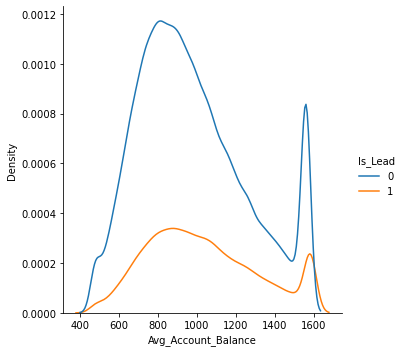

In [48]:
sns.displot(data=train,x='Avg_Account_Balance',hue='Is_Lead',kind='kde')

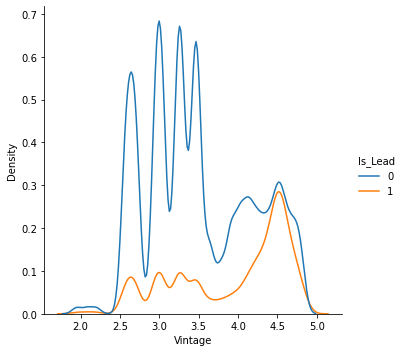

In [49]:
sns.displot(data=train,x='Vintage',hue='Is_Lead',kind='kde')

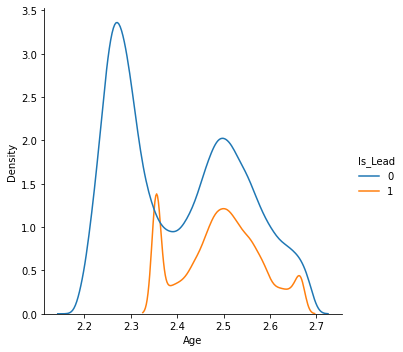

In [50]:
sns.displot(data=train,x='Age',hue='Is_Lead',kind='kde')

### Data Encodings

In [57]:
train.head()

ID  Gender       Age Region_Code Channel_Code   Vintage  \
6   ETQCZFEJ       1  2.580949       RG282           X3  2.995732   
15  UJ2NJKKL       1  2.354716       RG268           X2  4.234107   
16  CNGSPYWS       0  2.469865       RG268           X3  4.574711   
17  VH7NBNNQ       0  2.563058       RG283           X3  2.708050   
20  7PMYNWB3       1  2.452606       RG269           X2  2.944439   

   Credit_Product  Avg_Account_Balance Is_Active  Is_Lead  Entrepreneur  \
6              No          1027.983463       Yes        1             0   
15             No           719.070928       Yes        1             0   
16            Yes          1510.795155        No        1             0   
17            Yes          1544.244799        No        1             0   
20            Yes          1000.824660        No        1             0   

    Other  Salaried  Self_Employed  
6       1         0              0  
15      0         0              1  
16      1         0              0  
17      1         0              0  
20      0         0              1

In [24]:
train['Gender'].replace({'Male':1,'Female':0},inplace=True)
test['Gender'].replace({'Male':1,'Female':0},inplace=True)

In [25]:
train=pd.concat([train.drop('Occupation',axis=1),pd.get_dummies(train['Occupation'])],axis=1)
test=pd.concat([test.drop('Occupation',axis=1),pd.get_dummies(test['Occupation'])],axis=1)

In [26]:
train=pd.concat([train.drop('Channel_Code',axis=1),pd.get_dummies(train['Channel_Code'])],axis=1)
test=pd.concat([test.drop('Channel_Code',axis=1),pd.get_dummies(test['Channel_Code'])],axis=1)

In [27]:
train['Credit_Product'].replace({'Yes':1,'No':0},inplace=True)
test['Credit_Product'].replace({'Yes':1,'No':0},inplace=True)

In [28]:
train['Is_Active'].replace({'Yes':1,'No':0},inplace=True)
test['Is_Active'].replace({'Yes':1,'No':0},inplace=True)

In [29]:
train=pd.concat([train.drop('Age_Bracket',axis=1),pd.get_dummies(train['Age_Bracket'])],axis=1)
test=pd.concat([test.drop('Age_Bracket',axis=1),pd.get_dummies(test['Age_Bracket'])],axis=1)

### Feature Engineering

In [30]:
def top_ten(x):
    return x.nlargest(10).sum()
def bottom_ten(x):
    return x.nsmallest(10).sum()


In [31]:
features(df=train,on_Col='Region_Code',col_Name='Re_Entrepreneur_Sum',out_Col='Entrepreneur',aggfunc='sum')

features(df=test,on_Col='Region_Code',col_Name='Re_Entrepreneur_Sum',out_Col='Entrepreneur',aggfunc='sum')
features(df=train,on_Col='Region_Code',col_Name='Re_Salaried_Sum',out_Col='Salaried',aggfunc='sum')
features(df=test,on_Col='Region_Code',col_Name='Re_Salaried_Sum',out_Col='Salaried',aggfunc='sum')
features(df=train,on_Col='Region_Code',col_Name='Re_Self_Employed_Sum',out_Col='Self_Employed',aggfunc='sum')
features(df=test,on_Col='Region_Code',col_Name='Re_Self_Employed_Sum',out_Col='Self_Employed',aggfunc='sum')
features(df=train,on_Col='Region_Code',col_Name='Re_Other_Sum',out_Col='Other',aggfunc='sum')
features(df=test,on_Col='Region_Code',col_Name='Re_Other_Sum',out_Col='Self_Employed',aggfunc='sum')
features(df=train,on_Col='Region_Code',col_Name='Re_Credit_Product_Sum',out_Col='Credit_Product',aggfunc='sum')
features(df=test,on_Col='Region_Code',col_Name='Re_Credit_Product_Sum',out_Col='Credit_Product',aggfunc='sum')

features(df=train,on_Col='Region_Code',col_Name='Re_Vintage_Avg',out_Col='Vintage',aggfunc='mean')
features(df=test,on_Col='Region_Code',col_Name='Re_Vintage_Avg',out_Col='Vintage',aggfunc='mean')

features(df=train,on_Col='Region_Code',col_Name='Re_Vintage_skew',out_Col='Vintage',aggfunc='skew')
features(df=test,on_Col='Region_Code',col_Name='Re_Vintage_skew',out_Col='Vintage',aggfunc='skew')
features(df=train,on_Col='Region_Code',col_Name='Re_Channel_X1_Sum',out_Col='X1',aggfunc='sum')
features(df=test,on_Col='Region_Code',col_Name='Re_Channel_X1_Sum',out_Col='X1',aggfunc='sum')
features(df=train,on_Col='Region_Code',col_Name='Re_Channel_X2_Sum',out_Col='X2',aggfunc='sum')
features(df=test,on_Col='Region_Code',col_Name='Re_Channel_X2_Sum',out_Col='X2',aggfunc='sum')
features(df=train,on_Col='Region_Code',col_Name='Re_Channel_X3_Sum',out_Col='X3',aggfunc='sum')
features(df=test,on_Col='Region_Code',col_Name='Re_Channel_X3_Sum',out_Col='X3',aggfunc='sum')
features(df=train,on_Col='Region_Code',col_Name='Re_Channel_X4_Sum',out_Col='X4',aggfunc='sum')
features(df=test,on_Col='Region_Code',col_Name='Re_Channel_X4_Sum',out_Col='X4',aggfunc='sum')
features(df=train,on_Col='Region_Code',col_Name='Re_Mid_Age_Sum',out_Col='Mid-Age',aggfunc='sum')
features(df=test,on_Col='Region_Code',col_Name='Re_Mid_Age_Sum',out_Col='Mid-Age',aggfunc='sum')
features(df=train,on_Col='Region_Code',col_Name='Re_Young_Sum',out_Col='Young',aggfunc='sum')
features(df=test,on_Col='Region_Code',col_Name='Re_Young_Sum',out_Col='Young',aggfunc='sum')
features(df=train,on_Col='Region_Code',col_Name='Re_Old_Sum',out_Col='Old',aggfunc='sum')
features(df=test,on_Col='Region_Code',col_Name='Re_Old_Sum',out_Col='Old',aggfunc='sum')
features(df=train,on_Col='Region_Code',col_Name='Re_Active',out_Col='Is_Active',aggfunc='sum')
features(df=test,on_Col='Region_Code',col_Name='Re_Active',out_Col='Is_Active',aggfunc='sum')
features(df=train,on_Col='Region_Code',col_Name='Re_Balance_Avg',out_Col='Avg_Account_Balance',aggfunc='mean')
features(df=test,on_Col='Region_Code',col_Name='Re_Balance_Avg',out_Col='Avg_Account_Balance',aggfunc='mean')

features(df=train,on_Col='Region_Code',col_Name='Re_Balance_skew',out_Col='Avg_Account_Balance',aggfunc='skew')
features(df=test,on_Col='Region_Code',col_Name='Re_Balance_skew',out_Col='Avg_Account_Balance',aggfunc='skew')

features(df=train,on_Col='Region_Code',col_Name='Re_Balance_std',out_Col='Avg_Account_Balance',aggfunc='std')
features(df=test,on_Col='Region_Code',col_Name='Re_Balance_std',out_Col='Avg_Account_Balance',aggfunc='std')

features(df=train,on_Col='Region_Code',col_Name='Re_Balance_top',out_Col='Avg_Account_Balance',aggfunc=top_ten)
features(df=test,on_Col='Region_Code',col_Name='Re_Balance_top',out_Col='Avg_Account_Balance',aggfunc=top_ten)

features(df=train,on_Col='Region_Code',col_Name='Re_Balance_bottom',out_Col='Avg_Account_Balance',aggfunc=bottom_ten)
features(df=test,on_Col='Region_Code',col_Name='Re_Balance_bottom',out_Col='Avg_Account_Balance',aggfunc=bottom_ten)



ID  Gender       Age Region_Code   Vintage  Credit_Product  \
0       VBENBARO       1  2.203396       RG254  3.218876               1   
1       CCMEWNKY       1  2.352545       RG268  3.891820               0   
2       VK3KGA9M       1  2.229788       RG270  2.639057               0   
3       TT8RPZVC       1  2.203396       RG272  3.496508               0   
4       SHQZEYTZ       0  2.203396       RG270  2.944439               0   
...          ...     ...       ...         ...       ...             ...   
105307  DBENJOYI       1  2.418973       RG268  4.454347               1   
105308  CWQ72DWS       1  2.437930       RG277  4.454347               1   
105309  HDESC8GU       1  2.276600       RG254  2.708050               0   
105310  2PW4SFCA       1  2.425444       RG254  4.532599               0   
105311  F2NOYPPZ       1  2.174580       RG256  3.044522               0   

        Avg_Account_Balance  Is_Active  Entrepreneur  Other  Salaried  \
0                861.606639          0             0      1         0   
1                962.048336          0             0      1         0   
2                469.227290          0             0      0         1   
3                931.702742          0             0      1         0   
4                810.609030          0             0      1         0   
...                     ...        ...           ...    ...       ...   
105307          1588.402421          1             0      0         1   
105308          1076.639680          0             0      1         0   
105309          1305.268938          0             0      0         1   
105310           858.590706          1             0      1         0   
105311           769.132628          0             0      0         1   

        Self_Employed  X1  X2  X3  X4  Mid-Age  Old  Young  \
0                   0   1   0   0   0        0    0      1   
1                   0   0   1   0   0        1    0      0   
2                   0   1   0   0   0        0    0      1   
3                   0   1   0   0   0        0    0      1   
4                   0   1   0   0   0        0    0      1   
...               ...  ..  ..  ..  ..      ...  ...    ...   
105307              0   0   1   0   0        0    1      0   
105308              0   0   1   0   0        0    1      0   
105309              0   0   0   0   1        1    0      0   
105310              0   0   0   1   0        0    1      0   
105311              0   1   0   0   0        0    0      1   

        Re_Entrepreneur_Sum  Re_Salaried_Sum  Re_Self_Employed_Sum  \
0                      97.0           3513.0                4725.0   
1                     302.0           2622.0                7433.0   
2                       9.0           1598.0                1005.0   
3                      18.0            717.0                 902.0   
4                       9.0           1598.0                1005.0   
...                     ...              ...                   ...   
105307                302.0           2622.0                7433.0   
105308                 29.0           1977.0                2161.0   
105309                 97.0           3513.0                4725.0   
105310                 97.0           3513.0                4725.0   
105311                  4.0            579.0                 308.0   

        Re_Other_Sum  Re_Credit_Product_Sum  Re_Vintage_Avg  Re_Vintage_skew  \
0             4725.0                   3051        3.615528         0.147527   
1             7433.0                   5188        3.860490        -0.485247   
2             1005.0                    724        3.204874         1.098065   
3              902.0                    585        3.535994         0.107106   
4             1005.0                    724        3.204874         1.098065   
...              ...                    ...             ...              ...   
105307        7433.0                   5188        3.860490        -0.485247  

In [32]:
train['Balance_to_Age']=train['Avg_Account_Balance']/train['Age']
test['Balance_to_Age']=test['Avg_Account_Balance']/test['Age']

train['Vintage_to_Age']=train['Vintage']/(12.0*train['Age'])
test['Vintage_to_Age']=test['Vintage']/(12.0*test['Age'])

In [33]:
train.head()

ID  Gender       Age Region_Code   Vintage  Credit_Product  \
6   ETQCZFEJ       1  2.580949       RG282  2.995732               0   
15  UJ2NJKKL       1  2.354716       RG268  4.234107               0   
16  CNGSPYWS       0  2.469865       RG268  4.574711               1   
17  VH7NBNNQ       0  2.563058       RG283  2.708050               1   
20  7PMYNWB3       1  2.452606       RG269  2.944439               1   

    Avg_Account_Balance  Is_Active  Is_Lead  Entrepreneur  Other  Salaried  \
6           1027.983463          1        1             0      1         0   
15           719.070928          1        1             0      0         0   
16          1510.795155          0        1             0      1         0   
17          1544.244799          0        1             0      1         0   
20          1000.824660          0        1             0      0         0   

    Self_Employed  X1  X2  X3  X4  Mid-Age  Old  Young  Re_Entrepreneur_Sum  \
6               0   0   0   1   0        0    1      0                 42.0   
15              1   0   1   0   0        1    0      0                692.0   
16              0   0   0   1   0        1    0      0                692.0   
17              0   0   0   1   0        0    1      0                600.0   
20              1   0   1   0   0        1    0      0                 52.0   

    Re_Salaried_Sum  Re_Self_Employed_Sum  Re_Other_Sum  \
6            2191.0                1998.0        1598.0   
15           6061.0               17773.0       11406.0   
16           6061.0               17773.0       11406.0   
17           4992.0               14362.0        9462.0   
20           2688.0                2988.0        2135.0   

    Re_Credit_Product_Sum  Re_Vintage_Avg  Re_Vintage_skew  Re_Channel_X1_Sum  \
6                    1362        3.508374         0.332379             3234.0   
15                  12470        3.865975        -0.478601             9638.0   
16                  12470        3.865975        -0.478601             9638.0   
17                  10213        3.861898        -0.482962             7780.0   
20                   1718        3.498512         0.335617             3670.0   

    Re_Channel_X2_Sum  Re_Channel_X3_Sum  Re_Channel_X4_Sum  Re_Mid_Age_Sum  \
6              1458.0             1022.0              115.0          1670.0   
15            11123.0            14467.0              704.0         14085.0   
16            11123.0            14467.0              704.0         14085.0   
17             9286.0            11754.0              596.0         11501.0   
20             2110.0             1860.0              223.0          2409.0   

    Re_Young_Sum  Re_Old_Sum  Re_Active  Re_Balance_Avg  Re_Balance_skew  \
6         2657.0      1502.0       1731      943.415417         0.385430   
15        6203.0     15644.0      17821     1119.621012         0.078496   
16        6203.0     15644.0      17821     1119.621012         0.078496   
17        5156.0     12759.0      14847     1123.238350         0.072207   
20        3324.0      2130.0       2443      956.919797         0.702032   

    Re_Balance_std  Re_Balance_top  Re_Balance_bottom  Balance_to_Age  \
6       232.482387    15843.113646        4724.018417      398.296671   
15      280.457871    15843.113646        4724.018417      305.374820   
16      280.457871    15843.113646        4724.018417      611.691407   
17      281.418065    15843.113646        4724.018417      602.500962   
20      253.440218    15843.113646        4724.018417      408.065846   

    Vintage_to_Age  
6         0.096726  
15        0.149845  
16        0.154351  
17        0.088048  
20        0.100045

In [34]:
train.drop(['ID','Region_Code','Age'],axis=1,inplace=True)
test.drop(['ID','Region_Code','Age'],axis=1,inplace=True)

### Data Pre-Processing

In [35]:
num_cols=[ 'Vintage','Avg_Account_Balance','Re_Entrepreneur_Sum', 'Re_Salaried_Sum', 'Re_Self_Employed_Sum',
       'Re_Other_Sum', 'Re_Credit_Product_Sum', 'Re_Vintage_Avg',
       'Re_Vintage_skew', 'Re_Channel_X1_Sum', 'Re_Channel_X2_Sum',
       'Re_Channel_X3_Sum', 'Re_Channel_X4_Sum', 'Re_Mid_Age_Sum',
       'Re_Young_Sum', 'Re_Old_Sum', 'Re_Active', 'Re_Balance_Avg',
       'Re_Balance_skew', 'Re_Balance_std', 'Re_Balance_top',
       'Re_Balance_bottom', 'Balance_to_Age', 'Vintage_to_Age']

In [36]:
train_num=train.loc[:,num_cols]
test_num=test.loc[:,num_cols]

In [37]:
nrm=Normalizer().fit(train_num)
train_num=pd.DataFrame(nrm.transform(train_num),columns=num_cols)
test_num=pd.DataFrame(nrm.transform(test_num),columns=num_cols)

In [38]:
train.reset_index(drop=True,inplace=True)
train_num.reset_index(drop=True,inplace=True)
test.reset_index(drop=True,inplace=True)
test_num.reset_index(drop=True,inplace=True)

In [39]:
train=pd.concat([train.drop(num_cols,axis=1),train_num],axis=1)
test=pd.concat([test.drop(num_cols,axis=1),test_num],axis=1)

In [40]:
target=train['Is_Lead'].astype('int32')
train=train.drop('Is_Lead',axis=1)

In [41]:
oversample=SMOTE(sampling_strategy=.55)
X,y=oversample.fit_resample(train,target)

In [42]:
X_train,X_val,y_train,y_val=tts(X,y,test_size=.30,random_state=100)

In [93]:
train_data=pd.concat([X_train,y_train],axis=1)

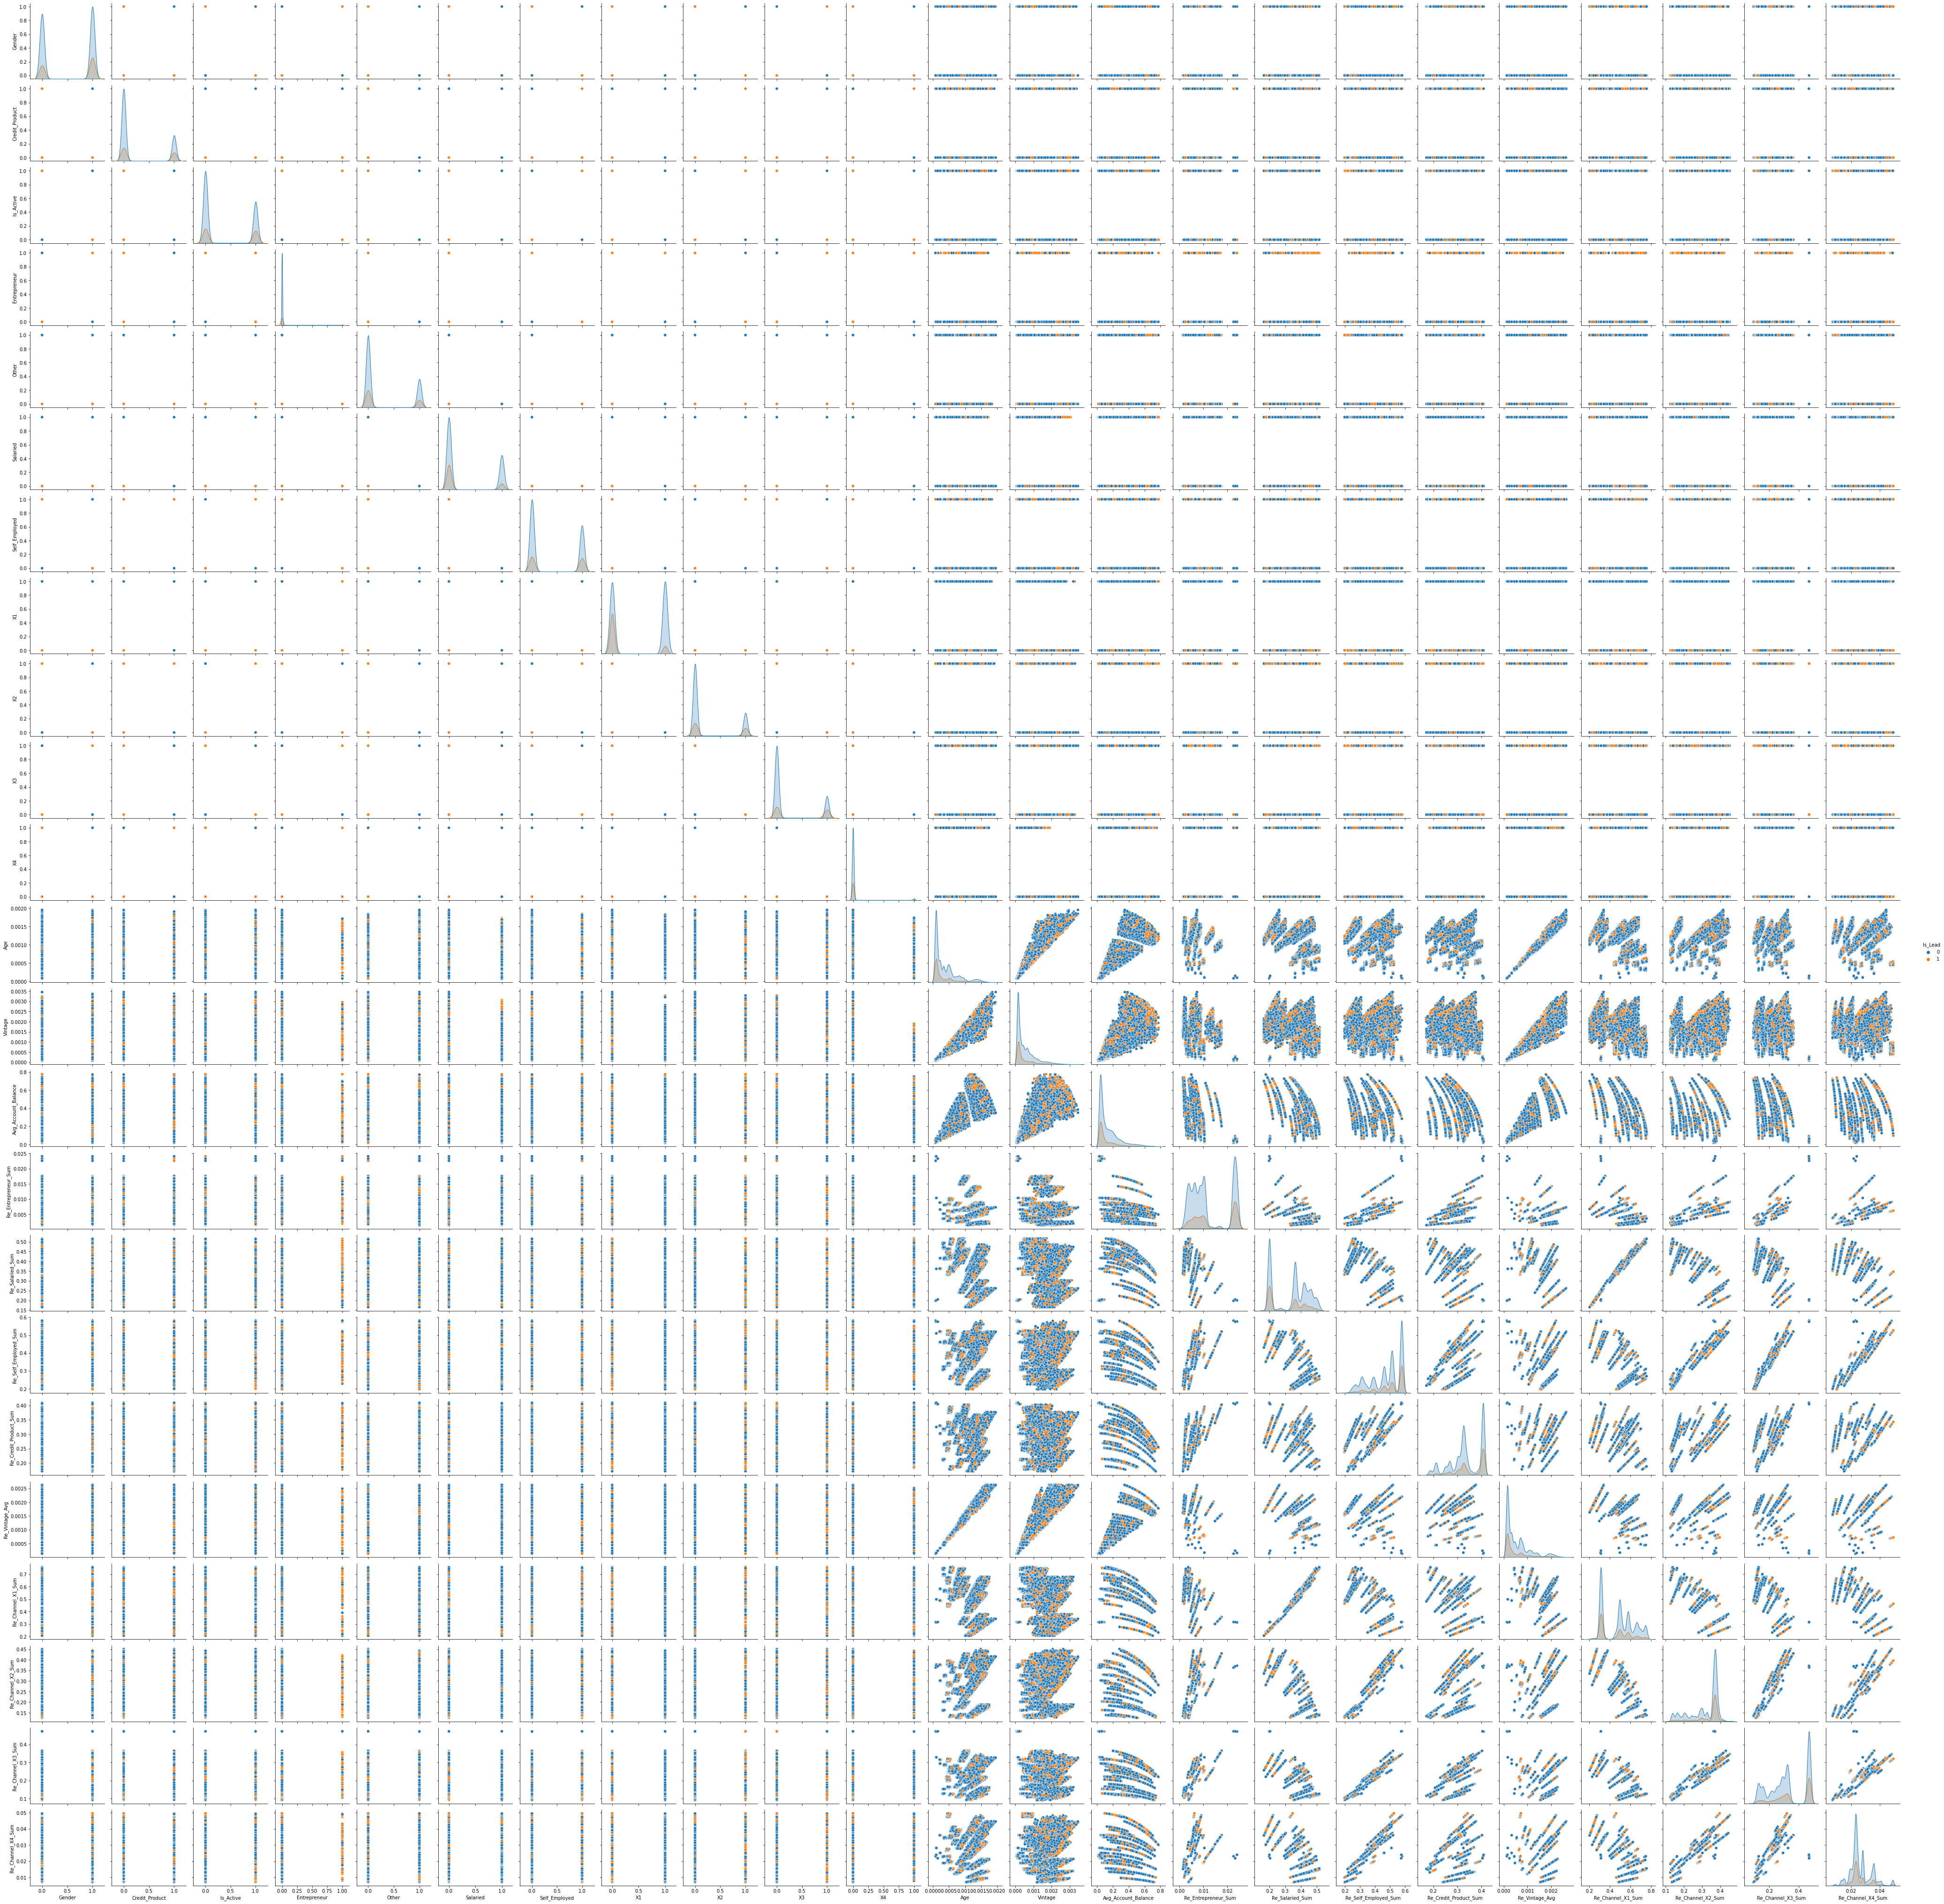

In [94]:
sns.pairplot(train_data,hue='Is_Lead')

In [3]:
X_train=pd.read_csv('X_train.csv')
X_val=pd.read_csv('X_val.csv')
y_train=pd.read_csv('y_train.csv')
y_val=pd.read_csv('y_val.csv')
test=pd.read_csv('Final_Test.csv')

In [4]:
y_val.value_counts()/y_val.shape[0]

Is_Lead
0          0.643452
1          0.356548
dtype: float64